# Overview

This document covers the transformation of ICESat-2 photon data over a target reef to depth estimates that will be used to calibrate Sentinel-2 bathymetry estimates.  The relevant program files are located in the <i><b>/src</i></b> directory in Karan Sunil's "Coral-Reef-Bathymetry" distribution on GitHub: https://github.com/karans04/Coral-Reef-Bathymetry

## 1.) Import packages

To begin, make sure this notebook is located and launched from a working directory containing <i><b>Depth_profile.py</i></b> and the other python files in Karan's distribution. After the imports below, any function available in <i><b>Depth_profile.py</i></b> can be called from this notebook with the syntax: depth.function_name(parameters). The same goes for the other imported python files.

Note: sentinelsat is a package external to Anaconda3.  Downloaded the package from ESA, unzip, cd into it, then install into the base environment using /opt/anaconda3/bin/pip3 install sentinelsat or into a virtual environment using /opt/anaconda3/envs/[env name]/bin/pip3 install sentinelsat.

Also, to get Beautiful Soup to work, I had to install the lxml library from the command line: conda install --name rasteriok lxml

In [74]:
import cmocean
import geopandas as gpd
import h5py
import importlib
import json
import lxml
import math
import matplotlib
import numpy as np
import os
import pandas as pd
import pyproj as proj
import rasterio
import requests
import seaborn as sns
import sys
import time
import zipfile

from bs4 import BeautifulSoup
from datetime import datetime
from itertools import product
from pathlib import Path
from scipy.stats import pearsonr
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from sklearn.cluster import DBSCAN
from shapely.geometry import Point
from timeit import default_timer as timer

import Coral_Reef as coral_reef
#import ATL03_API as is2_api
import Depth_profile as depth
import ICESat2_plots as is2_plot
import ICESat2_file as is2_file
import Sentinel_API as sentinel
import Sentinel2_image as s2_img
import Sentinel_plots as s2_plot
import Reef_plots as reef_plots
import Pixel_transformation as pt
import Tide_API as tide
import Water_level as water_level

import icepyx as ipx
import shutil

%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

## 2.) Input metadata for reef processing and initialize Coral_Reef data object

[run_bathymetry.py] <p>
In Karan's top-level processing script <i><b>run_bathymetry.py</i></b>, the reef processing parameters are taken from <i><b>metadata/[reef_name]_params.json</i></b>, which we create below using the specified parameters. Separately, place the reef outline GeoJSON file described below into the metadata directory for this reef:
<blockquote><b>A.)</b> a GeoJSON file containing the outline of the reef, named <i><b>[reef_name].geojson</i></b>.  This file is obtained from http://geojson.io/#map=2/20.0/0.0.  Switch to "OSM" or "Satellite" in bottom left corner of window (whatever shows reef best), select "polygon" mode at top-right, mark the boundary of reef with the cursor, save points using the menu at upper left (save->GeoJSON), then rename map.geojson file and move to data directory.</blockquote>
Then create a Coral_Reef object to hold metadata for each reef. Take a look in Coral_Reef.py for the methods and variables defined for the Coral_Reef class. Also note that the get_bounding_box( ) method queries <i><b>/metadata/[reef_name].geojson</i></b> to calculate the reef bounding box coordinates... so not sure why we need to include the bounds in <i><b>/metadata/[reef_name].txt</i></b>

In [75]:
#Declare project
reef_name = 'yap'#'pohnpei'
working_directory = '/Users/bonnieludka/OneDrive - UC San Diego/SatelliteDerivedBathymetry/analysis/projects/'
metadata_directory = os.path.join(working_directory, reef_name, 'metadata')

#Processing Metadata
sentinel_start_date = '20190101'
sentinel_end_date = '20210501'
download_is2 = False  #False = use the data already downloaded 
download_sentinel = False  #False = use the data already downloaded
earthdata_username = 'bludka'
earthdata_email = 'bludka@ucsd.edu'
earthdata_password = 'Gnidlaps10!'
sentinel_cloud_cover_percentage = [0, 10] #[min%, max%]
sentinel_username = 'bludka'
sentinel_password = 'Gnidlaps10!'
world_tide_API_key = 'fee8ff39-48eb-42a7-bcc5-3819fce3c1e4'

#Write Metadata
metadata_file = os.path.join(metadata_directory, reef_name + '_params.json')
metadata = {
    'reef_name': reef_name,
    'sentinel_start_date': sentinel_start_date,
    'sentinel_end_date': sentinel_end_date,
    'download_is2': download_is2,
    'download_sentinel': download_sentinel,
    'earthdata_username': earthdata_username,
    'earthdata_password': earthdata_password,
    'sentinel_username': sentinel_username,
    'sentinel_password': sentinel_password,
    'world_tide_API_key': world_tide_API_key,
    'sentinel_cloud_cover_percentage': sentinel_cloud_cover_percentage,
    'num_sentinel_imgs': 0    
}
with open(metadata_file, 'w') as json_file:
  json.dump(metadata, json_file, indent = 4)

#Initialize Coral_Reef data object
reef = coral_reef.Coral_Reef(reef_name, working_directory)

## 3a.) Download Sentinel-2 images

[Sentinel_API.py/get_sentinel_images()]

In [3]:
download = 0

if download == 1:

    #Set data path
    sentinel_path = reef.get_sentinel_rawdata_path()
    
    #Load geojson of reef
    reef_gjson_fp = os.path.join(reef.get_metadata_dir(), reef.get_reef_name()+'.geojson')
    reef_gjson = read_geojson(reef_gjson_fp)
    #Make sure longitude is within proper bounds
    coords = reef_gjson.features[0].geometry.coordinates[0]
    for i in range(len(coords)):
        coord = coords[i]
        coord[0] %= 360
    gsf = open(reef_gjson_fp, "w")
    json.dump(reef_gjson, gsf)
    gsf.close()
    reef_footprint = geojson_to_wkt(reef_gjson)

    #Query archive for relevant S2 scenes 
    api = SentinelAPI(sentinel_username, sentinel_password, 'https://scihub.copernicus.eu/dhus')
    products = api.query(reef_footprint,date = (sentinel_start_date, sentinel_end_date),\
            platformname = 'Sentinel-2', area_relation = 'Intersects', processinglevel = 'Level-2A',\
            cloudcoverpercentage = sentinel_cloud_cover_percentage, order_by = 'cloudcoverpercentage')  
    print('Number of scenes: {}'.format(len(products)))

    #Download files that are not yet local
    for i,x in enumerate(products.items()):
        k,v = x[0],x[1]
        safe_folder = os.path.join(sentinel_path, v['title'] + '.SAFE')
        if not os.path.exists(safe_folder):
            print('Downloading: {}'.format(safe_folder))
            api.download(k, directory_path = sentinel_path)
        else:
            print('{} exists!'.format(safe_folder))
        
    #Unzip files
    for file in os.listdir(sentinel_path):
        if file.endswith('.zip'):
            file_path = os.path.join(sentinel_path, file)
            out_path = os.path.join(sentinel_path, file.split('.')[0])

            if os.path.exists(file_path) and not os.path.exists(out_path):
                with zipfile.ZipFile(file_path,"r") as zip_ref:
                    zip_ref.extractall(sentinel_path)
                os.remove(file_path)

## 3b.) Extract Sentinel-2 image data

[Pixel_transformation.py/all_safe_files(reef)]<p>
Band 02 = Blue, Band 03 = Green, Band 04 = Red, Band 08 = Infrared.  All are 10 m resolution.

In [6]:
importlib.reload(s2_plot)
importlib.reload(s2_img)

#Set local parameters (these are set above, but repeated here)
reef_path = reef.get_reef_dir()
reef_name = reef.get_reef_name()
coords = reef.get_bounding_box()

#Choose Sentinel file for analysis
sentinel_files = [f for f in os.listdir(reef.get_sentinel_rawdata_path()) if f.endswith('.SAFE')]
sentinel_dates = [f[11:19] for f in sentinel_files]
#sentinel_dates.sort()
#print(*sentinel_files, sep='\n')

#Find dates of processed files
processed_sf = os.listdir(reef.get_sentinel_depths_path())
processed_dates = [f[-18:-10] for f in processed_sf if f.endswith('.csv')]
processed_dates.sort()

#Find files with no dates and set first of remaining files to be run
temp = set(processed_dates) 
result = [i for i, val in enumerate(sentinel_dates) if val not in temp] 
sf = [sentinel_files[i] for i in result]
if len(sf) > 0:
    print('Here are the unprocessed files:')
    print(*sf, sep='\n')
    sf = sf[0]
    print('Here is the file being processed:')
    print(sf)
else:
    print('All SAFE files have been processed at least once.')
    print('Here are the processed files:')
    print(*sentinel_files, sep='\n')
    sf = sentinel_files[0]
    print('Here is the file being reprocessed:')
    print(sf)
    

All SAFE files have been processed at least once.
Here are the processed files:
S2A_MSIL2A_20190303T012421_N0211_R131_T53PRL_20190303T030639.SAFE
S2B_MSIL2A_20200221T012419_N0214_R131_T53PRL_20200221T031307.SAFE
S2A_MSIL2A_20191208T012421_N0213_R131_T53PRL_20191208T030236.SAFE
S2A_MSIL2A_20200416T012431_N0214_R131_T53PRL_20200416T032431.SAFE
S2A_MSIL2A_20190522T012431_N0212_R131_T53PRL_20190522T031349.SAFE
S2B_MSIL2A_20190616T012439_N0212_R131_T53PRL_20190616T025849.SAFE
S2B_MSIL2A_20200531T012429_N0214_R131_T53PRL_20200531T033208.SAFE
S2B_MSIL2A_20190527T012439_N0212_R131_T53PRL_20190527T030601.SAFE
S2B_MSIL2A_20190328T012429_N0211_R131_T53PRL_20190328T063030.SAFE
S2A_MSIL2A_20200117T012421_N0213_R131_T53PRL_20200117T031055.SAFE
Here is the file being reprocessed:
S2B_MSIL2A_20200221T012419_N0214_R131_T53PRL_20200221T031307.SAFE


B8: robust sigma 225.35  mask threshold 450.70
Blue/Green plotbounds: -0.6725554008410395 0.6431037749896271
Green/Red plotbounds: -0.34429260001526596 1.408139923454254
Aerosol/Blue plotbounds: -0.889065237665789 0.5045378387646742
Aerosol/Red plotbounds: -0.9571407577076843 1.6156127248918641


<Figure size 1224x1224 with 0 Axes>

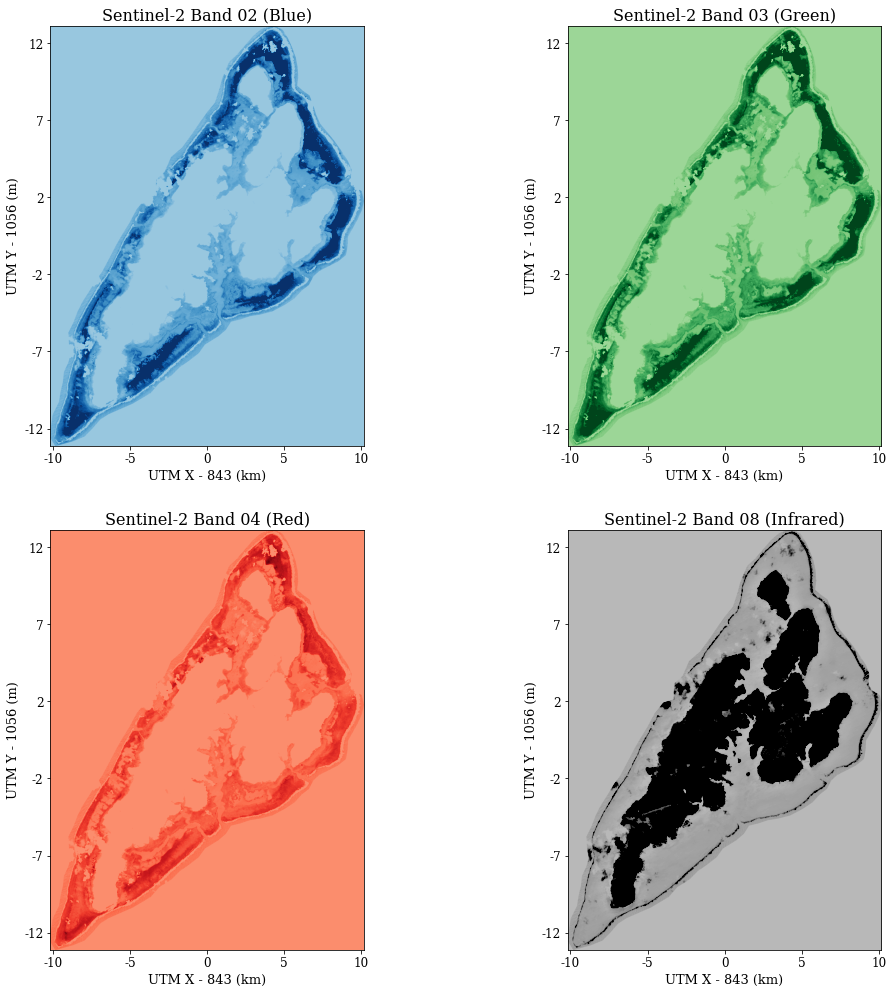

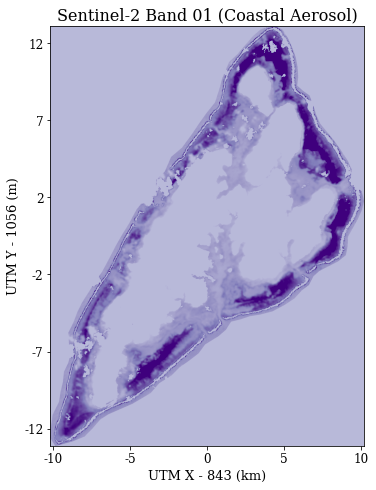

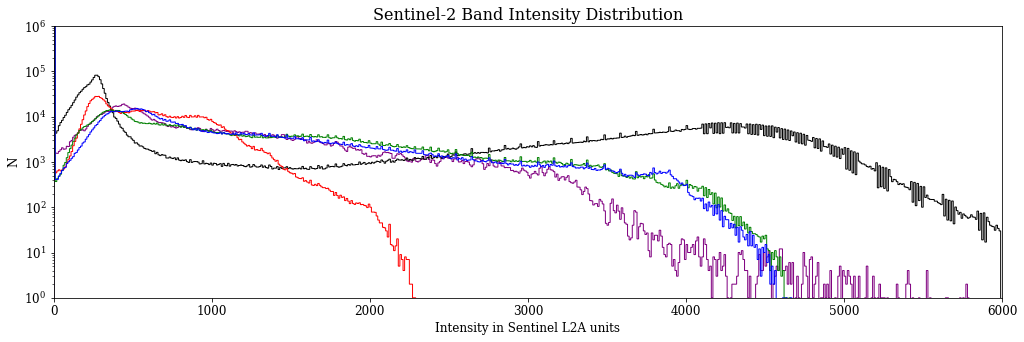

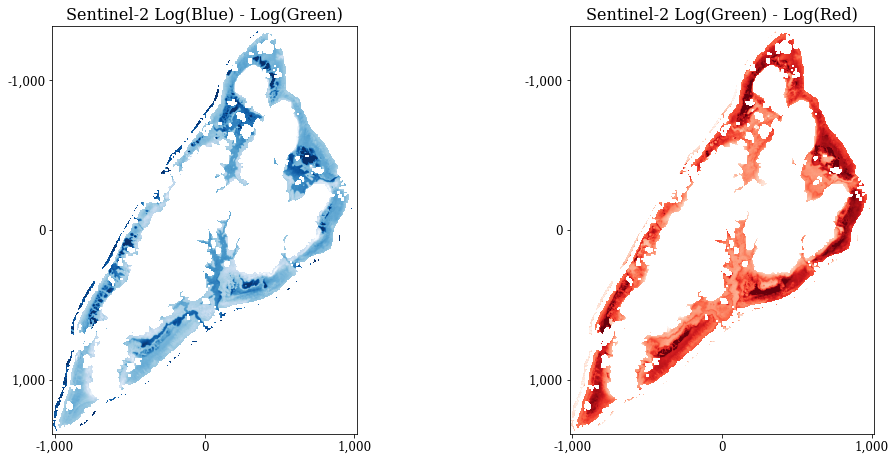

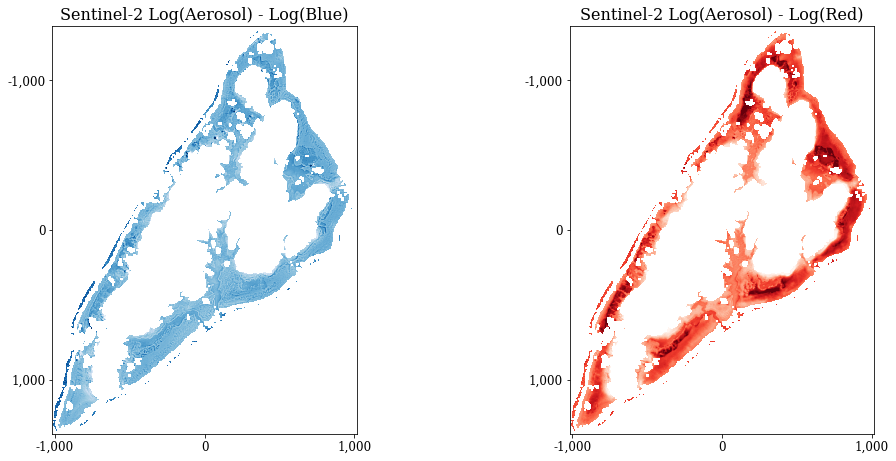

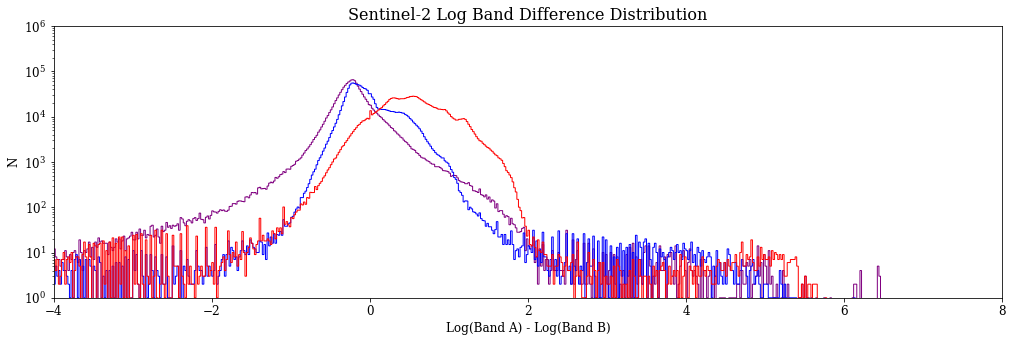

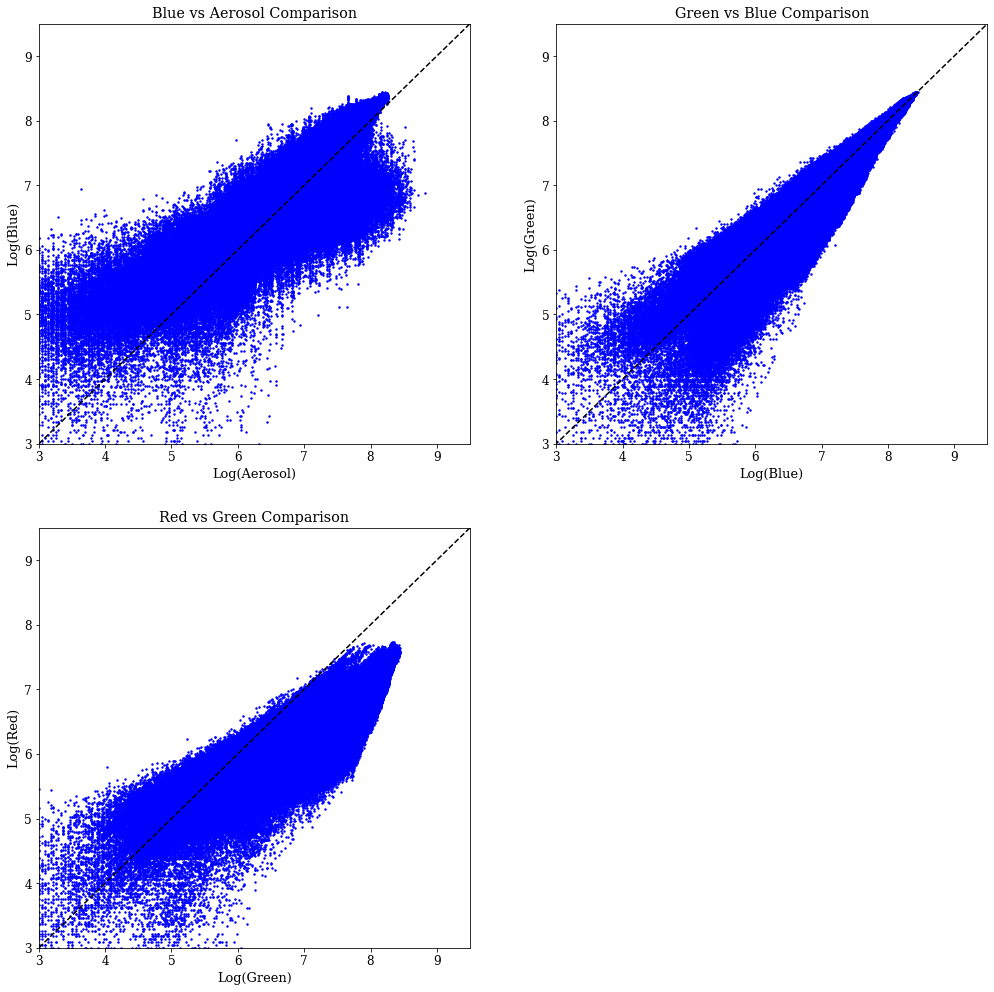

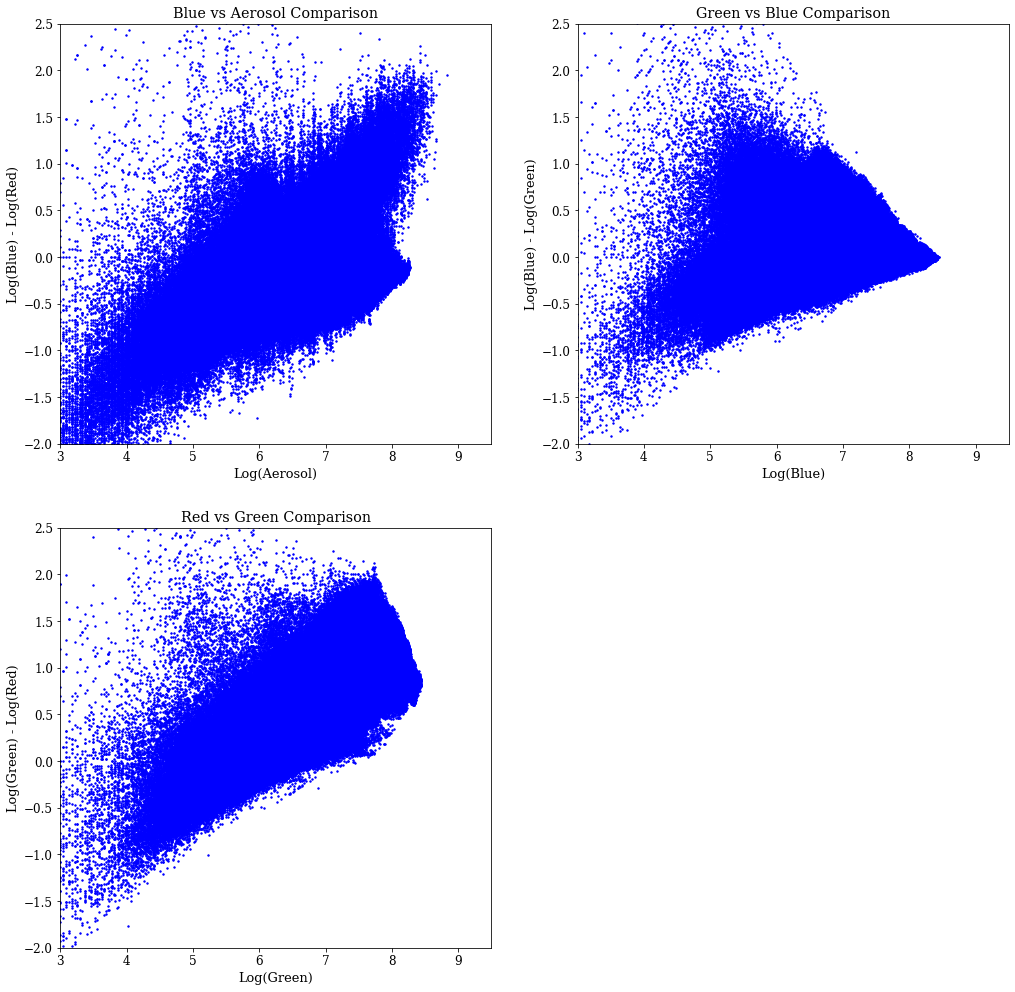

In [7]:
importlib.reload(s2_plot)
importlib.reload(s2_img)

#Load Sentinel file into data object
sf_path = os.path.join(reef.get_sentinel_rawdata_path(), sf)
safe_file = s2_img.Sentinel2_image(reef, sf_path, coords)

#Extract the Sentinel metadata and bands
meta = safe_file.get_meta()   #this has metadata in UTM coords. MAYBE CAN SEPARATE IMAGES FROM METADATA
imgs = meta['imgs']

#Create infrared threshold value for masking land/clouds
b8_flat = np.ndarray.flatten(imgs[3])  #make list of all Band 8 pixel values

#Create infrared threshold value for masking land/clouds
b8_flat = np.ndarray.flatten(imgs[3])  #make list of all Band 8 pixel values
b8_robust_sigma = np.subtract(*np.percentile(b8_flat, [75, 25]))/1.349
mask_thresh = np.median(b8_flat) + 2*b8_robust_sigma  #threshold is median val + 2*sigma
safe_file.meta['mask_thresh'] = mask_thresh
print('B8: robust sigma {0:5.2f}  mask threshold {1:5.2f}'.format(b8_robust_sigma, mask_thresh))

#Plot sentinel data
#flag = 'green_high'
flag = ""
s2_plot.plot_s2_band_raw(meta)
#print(meta['xdim'])

s2_plot.plot_s2_band_histogram(meta)
s2_plot.plot_s2_band_diff(meta, flag)
s2_plot.plot_s2_band_diff_histogram(meta)
s2_plot.plot_s2_band_vs_band(meta)
#s2_plot.plot_s2_band_ratio(meta) #test of log(B2)/log(B3) [doesn't help]

## 4.) Get ICESat-2 data for reef

[run_bathymetry.py] <p>
This requires running <i><b>/code/ATL03_API.main()</i></b>, which we are not going to do for this example. ICESat-2 HDF5 files will be downloaded into the <i><b>data/is2_photons</i></b> folder, and optionally those with little/bad data will be culled and put into <i><b>is2_photons_bad</i></b> folder.
<p>The ICESat-2 ATL03 data files are HDF5 files that can be obtained manually from OpenAltimetry (http://www.openaltimetry.org) or from NASA EarthData search (https://search.earthdata.nasa.gov/search/granules?p=C1705401930-NSIDC_ECS)

In [8]:
#importlib.reload(is2_api)

#is2_api.main(reef, earthdata_username, earthdata_password)


## Get ICESat-2 data for reef using icepyx https://github.com/icesat2py/icepyx
# put in for loop to decide whether need to download

download = 0

if download == 1:

    # specify date range
    # use same start/end dates as sentinel dates (or can specify other dates. date format is 'yyyy-mm-dd' string)
    is2_start_date = sentinel_start_date[0:4]+'-'+sentinel_start_date[4:6]+'-'+sentinel_start_date[6:8]
    is2_end_date = sentinel_end_date[0:4]+'-'+sentinel_end_date[4:6]+'-'+sentinel_end_date[6:8]
    date_range = [is2_start_date,is2_end_date]

    # specify spatial extent
    # use reef bounds
    reef_gjson_fp = os.path.join(reef.get_metadata_dir(), reef.get_reef_name()+'.geojson')
    reef_gjson = read_geojson(reef_gjson_fp)
    coords = reef_gjson.features[0].geometry.coordinates[0]
    spatial_extent = [] 
    for i in range(len(coords)):
        coord = coords[i]
        lon = coord[0]
        lat = coord[1]
        spatial_extent.append((lon,lat))
    #print(spatial_extent)
    # Hrm..the complex spatial extent seems to have issues
    # https://github.com/ICESat2-SlideRule/sliderule-python/issues/24
    # https://github.com/icesat2py/icepyx/issues/159
    # Use square bounding box for now but this is not an all the time fix (will break under some scenarios I think)
    se = np.array(spatial_extent)
    lon = se[:,0]
    lat = se[:,1]
    box_around_spatial_extent = [np.min(lon), np.min(lat), np.max(lon), np.max(lat)]
    print(box_around_spatial_extent)

    # create query for specified spatial extent and date range
    #region = ipx.Query('ATL03', spatial_extent, date_range) # grab data within complex polygon matching reef outline
    region = ipx.Query('ATL03', box_around_spatial_extent, date_range) # grab data within square bounding box
    region.visualize_spatial_extent()
    print(region.CMRparams)
    print(region.avail_granules())
    print(region.avail_granules(ids=True))

    # log in
    earthdata_email = 'bludka@ucsd.edu'
    region.earthdata_login(earthdata_username, earthdata_email)

    # request parameters
    # these come recommended: https://github.com/icesat2py/icepyx/blob/main/examples/ICESat-2_DAAC_DataAccess_Example.ipynb
    region.reqparams['page_size'] = 10
    region.reqparams['page_num'] = 1
    region.reqparams['request_mode'] = 'async'
    #region.reqparams['agent'] = 'NO' # This threw an error
    region.reqparams['include_meta'] = 'Y'
    print(region.reqparams)

    # subset variables to extract in query
    region.order_vars.append(var_list=['h_ph','lat_ph','lon_ph','signal_conf_ph','ref_azimuth','ref_elev'])
    #print(region.order_vars.wanted)
    region.subsetparams(Coverage=region.order_vars.wanted)

    # place order
    region.order_granules()
    h5_dir = reef.get_icesat_rawdata_path()
    region.download_granules(h5_dir)

## 5.) Read photon data, calculate photon depths relative to sea surface, save data

[run.py / Depth_profile.py / get_depths(reef) / process_H5()]<p>
Assuming for now that the ICESat-2 data have been downloaded and dropped into the <i><b>H5</i></b> directory.
The depth.process_H5(reef) method will run the entire depth estimation workflow. Here it is line-by-line:

In [57]:
#importlib.reload(depth)
remake_is2_bathymetry = 0

if remake_is2_bathymetry == 1:

    #importlib.reload(depth)

    #Get IS2 file directory and filenames
    h5_dir = reef.get_icesat_rawdata_path()
    h5_filenames = [f for f in os.listdir(h5_dir) if not f.startswith('.')]
    h5_filenames.sort()
    #h5_filenames = [h5_filenames[0]]

    for h5_fn in h5_filenames:
        print('\n' + h5_fn)

        #Inititalize ICESat-2 file object
        is2 = is2_file.IS2_file(reef, h5_fn)
        is2_file_tag = is2.get_file_tag()
        strong_beams = is2.get_strong_lasers()
        print(strong_beams)
    
        for laser in strong_beams:

            #Output directory for csv file containing raw photon data
            photon_fn = '{reef_name}_photons_{h5_fn}_{laser}.csv'.format(reef_name=reef_name, h5_fn=is2_file_tag, laser=laser)
            photons_path = os.path.join(reef.get_icesat_photons_path(), photon_fn)
    
            #Load raw photon data from .CSV if it already exists, else extract data from subsetted IS2 H5 file
            if not os.path.exists(photons_path):

                #Create dataframe with photon data from subsetted IS2 H5 file
                photon_data = is2.get_photon_data(laser) 
                if len(photon_data) == 0:
                    print('No photons in file for {}'.format(laser))
                    continue            
                df_laser = depth.create_photon_df(photon_data)
                df_laser['beam'] = laser
                df_laser['date'] = is2.get_date()

                #Clip dataframe to reef bounding shape
                reef_polygon = reef.return_reef_polygon()
                gdf = gpd.GeoDataFrame(df_laser, geometry=gpd.points_from_xy(df_laser.Longitude, df_laser.Latitude))
                poly_gdf = gpd.GeoDataFrame([1], geometry=[reef_polygon])
                gdf_clipped = gpd.clip(gdf, poly_gdf)
                df = pd.DataFrame(gdf_clipped)
            
                #Optional: restrict photons to desired confidences
                df = df.loc[(df.Conf_ocean == 4) | (df.Conf_ocean == 3) | (df.Conf_ocean == 1) | (df.Conf_ocean == 0) | \
                        (df.Conf_land == 4) | (df.Conf_land == 3) | (df.Conf_ocean == 1) | (df.Conf_land == 0)].copy()
                #df = df.loc[(df.Conf_ocean == 4)  | (df.Conf_ocean == 3) | (df.Conf_ocean == 1) | \
                #        (df.Conf_land == 4) | (df.Conf_land == 3) | (df.Conf_ocean == 1)].copy()
                #df = df.loc[(df.Conf_ocean == 4)  | (df.Conf_ocean == 0) | \
                #        (df.Conf_land == 4) | (df.Conf_land == 0)].copy()
                #df = df.loc[(df.Conf_ocean == 4) | (df.Conf_land == 4)].copy()

                #If there are photons in the new clipped dataframe
                if len(df) != 0:    
            
                    #Adjust elevations to reference local sea level (tide correction comes later)
                    #Unlike Karan's code, df now contains 'sea_level', which has been removed from 'Heights'
                    df,f = water_level.normalise_sea_level(df)
                    #is2_plot.plot_is2_depths(df, is2, laser, f, [0, 55], 'Raw Photon Elevs')
                    if len(df) == 0:  
                        print('Failed at sea level parameterization for {}'.format(laser))
                        continue
                    is2.set_sea_level_function(f,laser)

                    #Adjust depth for speed of light in water
                    df = water_level.adjust_for_speed_of_light_in_water(df)

                    #Write a dataframe containing just the photon data in bounding box that meet the confidence criterion
                    df.to_csv(photons_path)
                else:
                    print('No photons over reef for {}'.format(laser))
            
            else:
                print('\n' + 'Reading photons from prior csv file for {}'.format(laser))
                df = pd.read_csv(photons_path)
                is2.metadata = is2.load_json()
               
            print('Number photons in {laser} is {reef_length}'.format(laser=laser, reef_length=str(len(df))))               
        
            #Classify seafloor photons
            eps_val = 0.75
            min_samp = 4
            water_thresh_low = -50
            water_thresh_high = -0.4
            smooth = 0.0002  #This is the smoothing interval along track in decimal degrees of latitude
            bathy = depth.apply_DBSCAN(df, eps_val, min_samp, water_thresh_low, water_thresh_high, safe_file, smooth)
            #smooth = 0  #Set smooth to zero to use raw bathymetric photons
            #bathy, non_bathy = depth.apply_DBSCAN(df, eps_val, min_samp, water_thresh_low, water_thresh_high, safe_file, smooth)
          
            if len(bathy) == 0:
                print('No bathymetric photons found for {}'.format(laser))
                continue
            print('Number bathy photons in {laser} is {reef_length}'.format(laser=laser, reef_length=str(len(bathy))))
  
            #Output just bathymetric photons to new .CSV file
            depths_fn = '{reef_name}_{h5_fn}_{laser}.csv'.format(reef_name=reef_name,h5_fn=is2_file_tag,laser=laser)
            bathymetry_output_path = os.path.join(reef.get_icesat_bathymetry_path(), depths_fn)
            bathy.to_csv(bathymetry_output_path)
        
            #Plot depths
            is2_plot.plot_is2_depths_bathy(df, is2, laser, bathy, reef.get_icesat_images_path(), 'False', [-20, 5], 'Corrected Bathymetric Profile')
        

## 6.) Get Training (Calibration) bathymetry data from ICESat-2 and Sentinel-2
[Pixel_transformation.py/get_regressor(reef, sf)]<br>
[Pixel_transformation.py/load_ICESAT_predictions(icesat_proc_path,sf)]

In [65]:
importlib.reload(pt)
importlib.reload(reef_plots)
importlib.reload(s2_plot)

#Get list of all ICESat bathymetry files
icesat_bathymetry_path = reef.get_icesat_bathymetry_path()
is2files = [file for file in os.listdir(icesat_bathymetry_path) if file.endswith('.csv')]
ist2filepaths = [os.path.join(icesat_bathymetry_path, fn) for fn in is2files]

#Define and populate ICESat training (calibration) dataframe; calculate and apply tides in pt.prep_df
frames = [pt.prep_df(safe_file, fp, safe_file.get_crs(),reef) for fp in ist2filepaths ]
print(frames)
train_raw = pd.concat(frames)
train_raw = train_raw.dropna()

#train_raw = pd.DataFrame()
#for fn in is2files:    
#    train_path = os.path.join(icesat_bathymetry_path, fn)
#    #pt.prep_df gets tides and corrects IS2 training bathymetry to depth valid for Sentinel-2 image date
#    train_raw = pd.concat([train_raw, pt.prep_df(safe_file, train_path, safe_file.get_crs(),reef)])   
#train_raw = train_raw.dropna()

#Define functions we need below
def get_pixel_val(coord):
    """
    Get pixel value given a set of coordinates
    Params - 1. coord (Point) - point of interest
    Return int - pixel value at point
    """
    x_index = int((coord.x - meta['ulx']) // meta['xdim'])
    y_index = int((coord.y - meta['uly']) // meta['ydim'])
    return [data[0][y_index][x_index] for data in imgs]

def get_pixel_x_index(coord):
    """
    Return pixel x index at a given set of coordinates
    """
    x_index = int((coord.x - meta['ulx']) // meta['xdim'])
    return x_index

def get_pixel_y_index(coord):
    """
    Return pixel y index at a given set of coordinates
    """
    y_index = int((coord.y - meta['uly']) // (meta['ydim']))  #note: ydim is negative
    return y_index

def extract_pixel_cols(df):
    """
    Extracts band values for image
    Params - 1. df (DataFrame) - depth predictions of ICESAT-2
    Return - DataFrame - pixel values added for each point
    """
    df['Pixels'] = df.Coordinates.apply(get_pixel_val)
    df['b2'] = df.Pixels.apply(lambda x: (x[0]))
    df['b3'] = df.Pixels.apply(lambda x: (x[1]))
    df['b4'] = df.Pixels.apply(lambda x: (x[2]))
    df['b8'] = df.Pixels.apply(lambda x: (x[3]))
    df['b1'] = df.Pixels.apply(lambda x: (x[4]))
    df.drop(columns=['Pixels'], inplace=True)
    return df

2020-07-02 12:21:53   S2 tide: -0.0540  IS2 tide: -0.0690
2020-12-06 16:51:26   S2 tide: -0.0540  IS2 tide: -0.1760
2020-03-09 05:52:01   S2 tide: -0.0540  IS2 tide: -0.0990
2019-04-05 10:03:04   S2 tide: -0.0540  IS2 tide:  0.5460
2019-03-11 23:13:01   S2 tide: -0.0540  IS2 tide:  0.3630
2020-12-31 03:41:34   S2 tide: -0.0540  IS2 tide: -0.1000
2019-06-10 18:52:37   S2 tide: -0.0540  IS2 tide:  0.2430
2020-01-02 21:02:19   S2 tide: -0.0540  IS2 tide: -0.3710
2020-09-06 21:11:36   S2 tide: -0.0540  IS2 tide: -0.1100
[      Unnamed: 0  Unnamed: 0.1    Height  Latitude   Longitude  Conf_land  \
0            156          2984 -5.747470  9.605204  138.189124        4.0   
1            160          2988 -5.795100  9.605191  138.189123        4.0   
2            162          2990 -6.170000  9.605184  138.189122        4.0   
3            166          2994 -5.787836  9.605171  138.189121        4.0   
4            168          2996 -5.852790  9.605171  138.189121        4.0   
...          ..

      Unnamed: 0  Unnamed: 0.1    Height  Latitude   Longitude  Conf_land  \
0            156          2984 -5.747470  9.605204  138.189124        4.0   
1            160          2988 -5.795100  9.605191  138.189123        4.0   
2            162          2990 -6.170000  9.605184  138.189122        4.0   
3            166          2994 -5.787836  9.605171  138.189121        4.0   
4            168          2996 -5.852790  9.605171  138.189121        4.0   
...          ...           ...       ...       ...         ...        ...   
5024       13806         18601 -0.621449  9.461174  138.042590        2.0   
5025       13807         18604 -0.596442  9.461180  138.042590        2.0   
5026       13812         18614 -0.938913  9.461199  138.042588        2.0   
5027       13814         18617 -1.036205  9.461206  138.042587        2.0   
5028       13819         18622 -0.834872  9.461212  138.042586        2.0   

      Conf_ocean  Conf_inlandwater  \
0            1.0              -1.0   

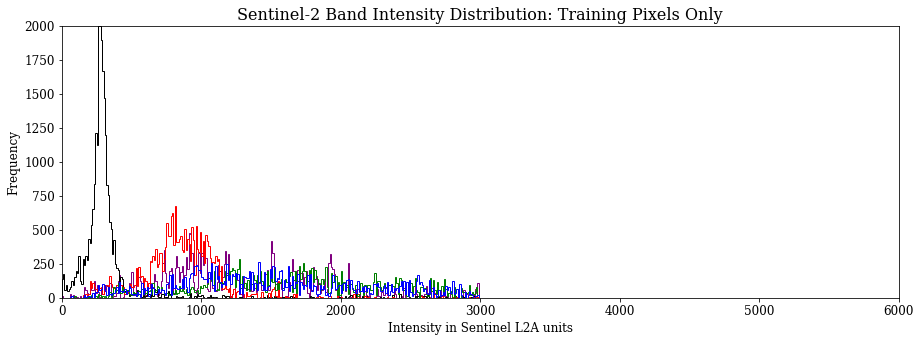

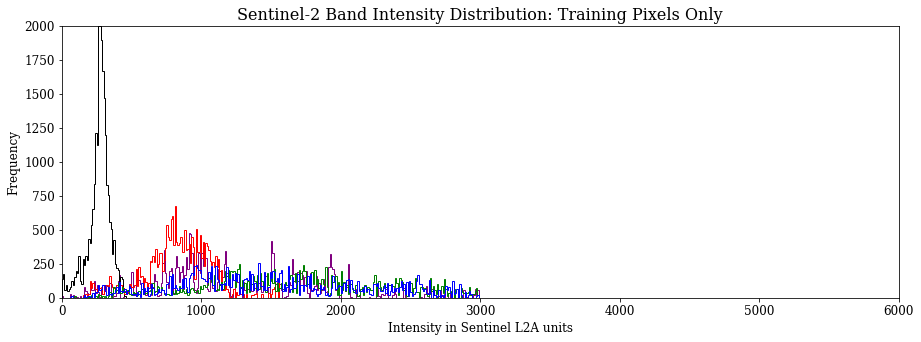

In [66]:
#Get Sentinel band values at IS2 pixel locations
train = train_raw.copy(deep=True)  #first make a copy of "train_raw" so it can be altered for each S2 image
train = extract_pixel_cols(train)
print(train)
print('hello')

#Plot histogram and print statistics of Sentinel calibration pixels before masking
print('')
print('Training pixel stats before masking land/clouds')
print('B2: min {0:5d}, max {1:5d}, mean {2:6.1f}, median {3:6.1f}'.format(min(train['b2']), max(train['b2']), np.mean(train['b2']), np.median(train['b2'])))
print('B3: min {0:5d}, max {1:5d}, mean {2:6.1f}, median {3:6.1f}'.format(min(train['b3']), max(train['b3']), np.mean(train['b3']), np.median(train['b3'])))
print('B4: min {0:5d}, max {1:5d}, mean {2:6.1f}, median {3:6.1f}'.format(min(train['b4']), max(train['b4']), np.mean(train['b4']), np.median(train['b4'])))
print('B8: min {0:5d}, max {1:5d}, mean {2:6.1f}, median {3:6.1f}'.format(min(train['b8']), max(train['b8']), np.mean(train['b8']), np.median(train['b8'])))
print('B1: min {0:5d}, max {1:5d}, mean {2:6.1f}, median {3:6.1f}'.format(min(train['b1']), max(train['b1']), np.mean(train['b1']), np.median(train['b1'])))
reef_plots.band_histogram(train)

#Apply land/cloud mask based on Band 8 (infrared)
print('')
print('Mask threshold: ', mask_thresh)
train['mask'] = train.b8.apply(lambda x: False if x < mask_thresh else True)
print('N photons before edits: ', len(train))
train = train.loc[(train.b2 != 0) & (train.b3 != 0)].copy()
print('N non-zero photons: ', len(train))
#train = train.loc[(train.b2 != 0) & (train.b3 != 0) & (train.b4 != 0)] #use this if training with Band 04 (red)
train = train.loc[train['mask'] == False].copy()
print('N Band8-masked non-zero photons: ',len(train))

#Plot histogram and print statistics of Sentinel calibration pixels after masking
print('')
print('Training pixel stats after removing zeros and masking land/clouds')
print('B2: min {0:5d}, max {1:5d}, mean {2:6.1f}, median {3:6.1f}'.format(min(train['b2']), max(train['b2']), np.mean(train['b2']), np.median(train['b2'])))
print('B3: min {0:5d}, max {1:5d}, mean {2:6.1f}, median {3:6.1f}'.format(min(train['b3']), max(train['b3']), np.mean(train['b3']), np.median(train['b3'])))
print('B4: min {0:5d}, max {1:5d}, mean {2:6.1f}, median {3:6.1f}'.format(min(train['b4']), max(train['b4']), np.mean(train['b4']), np.median(train['b4'])))
print('B8: min {0:5d}, max {1:5d}, mean {2:6.1f}, median {3:6.1f}'.format(min(train['b8']), max(train['b8']), np.mean(train['b8']), np.median(train['b8'])))
print('B1: min {0:5d}, max {1:5d}, mean {2:6.1f}, median {3:6.1f}'.format(min(train['b1']), max(train['b1']), np.mean(train['b1']), np.median(train['b1'])))
reef_plots.band_histogram(train)

#Ensure that no training pixels are zero or negative
#delta = 0.000
#dark_pixel = {'B02': delta, 'B03': delta, 'B04': delta}
#safe_file.meta['min_pix'] = dark_pixel
#train['b2'] = train['b2'].apply(lambda x: max(delta,x - dark_pixel['B02']))
#train['b3'] = train['b3'].apply(lambda x: max(delta,x - dark_pixel['B03']))
#train['b4'] = train['b4'].apply(lambda x: max(delta,x - dark_pixel['B04']))

#Get coordinates of training data for overplotting on sentinel image (coordinates generated in pt.prep_df)
train['x'] = train.Coordinates.x
train['y'] = train.Coordinates.y
train['image_coord_x'] = train.Coordinates.apply(get_pixel_x_index)
train['image_coord_y'] = train.Coordinates.apply(get_pixel_y_index)

train.drop(columns=['Coordinates'], inplace=True)

## 7.) Calibrate Sentinel-2 depth estimates

In [67]:
#start = timer()
#end = timer()
#print('First: ', end - start)
#start2 = timer()
#end2 = timer()
#print('Second: ', end2 - start2)
#print('Acceleration: ', (end2-start2)/(end-start))

Slope/Intercept Blue-Green: -0.092/-0.257
Slope/Intercept Green-Red : -0.092/-0.257
Slope/Intercept Aerosol-Blue : -0.092/-0.257


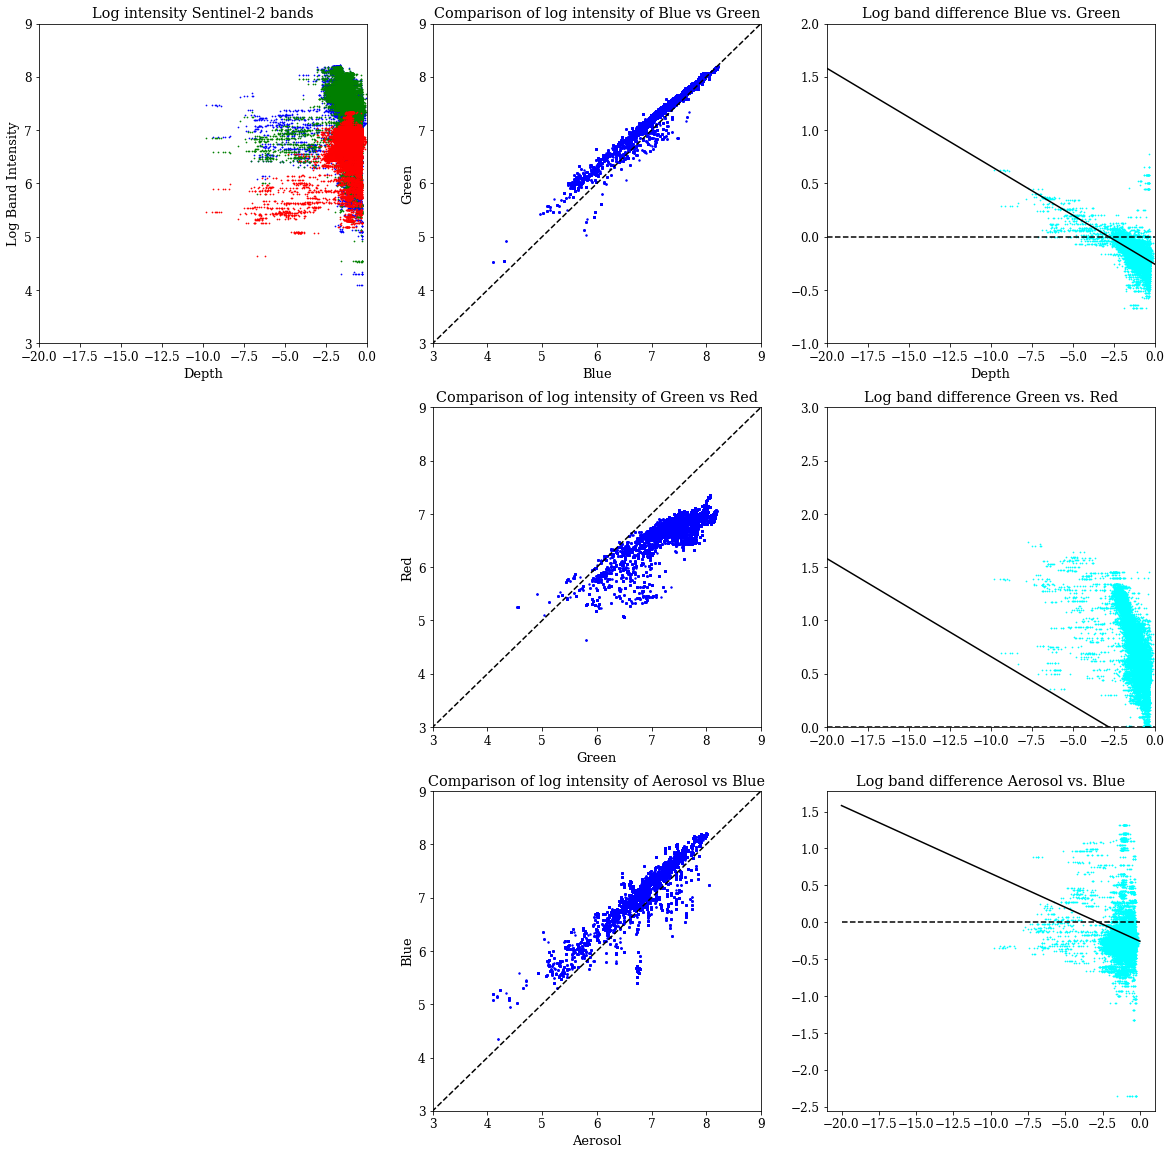

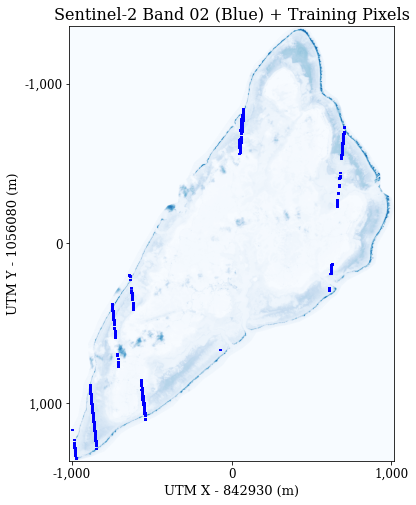

In [68]:
importlib.reload(reef_plots)

#Calculates the log difference between band pixels
train['log_b2'] = np.log(train['b2'])
train['log_b3'] = np.log(train['b3']) 
train['log_b4'] = np.log(train['b4']) 
train['log_b1'] = np.log(train['b1']) 
train['diff_b2_b3'] = train.eval('log_b2 - log_b3')
train['diff_b2_b4'] = train.eval('log_b2 - log_b4')
train['diff_b3_b4'] = train.eval('log_b3 - log_b4')
train['diff_b1_b2'] = train.eval('log_b1 - log_b2')

#Optionally edit data outliers
train_cleaned = train.copy(deep=True)  #first make a copy of "train" so it can be altered for each S2 image
#train_cleaned = pt.remove_log_outliers(train_cleaned)

#Relationships between calibration bathymetry and log band differences
#x = train_cleaned.loc[:,['Height']]
#y = train_cleaned.loc[:,['diff_b2_b3']]
x = train_cleaned.Height
y = train_cleaned.diff_b2_b3
x = x[~np.isinf(y)]
y = y[~np.isinf(y)]
m, c = np.polyfit(x, y, 1) #m = slope, c=intercept
#y2 = train_cleaned.loc[:,['diff_b3_b4']]
x = train_cleaned.Height
y2 = train_cleaned.diff_b3_b4
x = x[~np.isinf(y2)]
y2 = y[~np.isinf(y2)]
m2, c2 = np.polyfit(x, y2, 1) #m = slope, c=intercept
#y3 = train_cleaned.loc[:,['diff_b1_b2']]
x = train_cleaned.Height
y3 = train_cleaned.diff_b1_b2
x = x[~np.isinf(y3)]
y3 = y[~np.isinf(y3)]
m3, c3 = np.polyfit(x, y3, 1) #m = slope, c=intercept
print('Slope/Intercept Blue-Green: {0:6.3f}/{1:6.3f}'.format(m, c))
print('Slope/Intercept Green-Red : {0:6.3f}/{1:6.3f}'.format(m2, c2))
print('Slope/Intercept Aerosol-Blue : {0:6.3f}/{1:6.3f}'.format(m3, c3))

#Plot calibration results
reef_plots.plot_sentinel_cal(train_cleaned, m, c, m2, c2, m3, c3)

#Return training results for Blue/Green
line = lambda x: (x-c)/m
out = train_cleaned[['x','y','b2','b3','diff_b2_b3','Height']]
#Return training results for Green/Red
#line = lambda x: (x-c2)/m2  
#out = train_cleaned[['x','y','b3','b4','diff_b3_b4','Height']] 

#Output training file
training_data_out_fn = '{reef_name}_training_data_{date}.csv'.\
    format(reef_name = reef_name, date = safe_file.get_date().strftime("%Y%m%d%H%M%S"))
train_cleaned.to_csv(os.path.join(reef.get_training_data_path(), training_data_out_fn))

#Plot location of training data on reef
reef_plots.plot_sentinel_icesat(imgs, meta, train_cleaned)

## 8.) Get reef depths

Pixel_transformation.py/predict_reef

In [13]:
#restore parameters
meta = safe_file.get_meta()
mask_thresh = meta['mask_thresh']
tide_level = safe_file.get_tide()
bbox_coords = safe_file.read_gjson()['geometry'][0].bounds

#loads in the required images
imgs = meta['imgs']
indices = np.array(list(product(range(imgs[0].shape[1]), range(imgs[0].shape[2]))))
bands = pd.DataFrame()
bands['x'] = bbox_coords[0] + meta['xdim']/2 + indices[:,1]*meta['xdim']
bands['y'] = bbox_coords[3] - meta['ydim']/2 + indices[:,0]*meta['ydim']
bands['b2'] = np.ndarray.flatten(imgs[0]) #flatten by row
bands['b3'] = np.ndarray.flatten(imgs[1])
bands['b8'] = np.ndarray.flatten(imgs[3])

#do band math
bands['log_b2'] = np.log(bands['b2'])
bands['log_b3'] = np.log(bands['b3']) 
bands['log_b2'] = np.where(bands['b2'] == 0, np.nan, bands['log_b2'])
bands['log_b3'] = np.where(bands['b3'] == 0, np.nan, bands['log_b3'])
bands['diff_log_b2_b3'] = bands.eval('log_b2 - log_b3')
bands['diff_log_b2_b3'] = np.where(bands['b8'] > mask_thresh, np.nan, bands['diff_log_b2_b3'])
bands['Height'] = (line(bands['diff_log_b2_b3']) - tide_level)
#bands_out = bands.loc[(bands.diff_log_b2_b3 >= 0)].copy()

#create a dataframe with the output information 
reef_depths = bands[['x', 'y', 'Height']]

#Save df as a csv
dt = safe_file.get_date()
out_fn = '{reef_name}_out_{dt}.csv'.format(reef_name = reef.reef_name, dt = dt.strftime("%Y%m%d%H%M%S"))
out_fp = os.path.join(reef.get_sentinel_depths_path(), out_fn)
reef_depths.to_csv(out_fp)

## Plot reef depths

In [14]:
importlib.reload(reef_plots)

#Limits of ocean_topo colormap
vmin = -12
vmax = 7

reef_plots.plot_reefs(reef_depths, train_cleaned, safe_file, line, reef, vmin, vmax)


Done Plotting
Done Saving


# Compare to non-calibration IS2 depths

In [82]:
importlib.reload(pt)
importlib.reload(reef_plots)
importlib.reload(s2_plot)
importlib.reload(coral_reef)

#Get list of all ICESat bathymetry files
icesat_validation_path = reef.get_icesat_validation_path()
is2files = [file for file in os.listdir(icesat_validation_path) if file.endswith('.csv')]
ist2filepaths = [os.path.join(icesat_validation_path, fn) for fn in is2files]

#Define and populate ICESat validation dataframe; calculate and apply tides in pt.prep_df
frames = [pt.prep_df(safe_file, fp, safe_file.get_crs(),reef) for fp in ist2filepaths ]
validation = pd.concat(frames)
validation = validation.dropna()

#Get coordinates of training data for overplotting on sentinel image (coordinates generated in pt.prep_df)
validation['x'] = validation.Coordinates.x
validation['y'] = validation.Coordinates.y
validation['image_coord_x'] = validation.Coordinates.apply(get_pixel_x_index)
validation['image_coord_y'] = validation.Coordinates.apply(get_pixel_y_index)



2020-03-09 05:52:01   S2 tide: -0.0540  IS2 tide: -0.0990
2019-01-04 14:23:12   S2 tide: -0.0540  IS2 tide: -0.7200
2020-12-31 03:41:34   S2 tide: -0.0540  IS2 tide: -0.1000
2019-06-10 18:52:37   S2 tide: -0.0540  IS2 tide:  0.2430
2019-03-11 23:13:01   S2 tide: -0.0540  IS2 tide:  0.3630
2019-12-09 10:12:15   S2 tide: -0.0540  IS2 tide:  0.1820
2020-09-06 21:11:36   S2 tide: -0.0540  IS2 tide: -0.1100
2020-04-02 16:42:04   S2 tide: -0.0540  IS2 tide:  0.2020
2020-07-02 12:21:53   S2 tide: -0.0540  IS2 tide: -0.0690


In [85]:
print(validation)
print('hi')
print(reef_depths)
print(np.sum(np.isnan(reef_depths.Height)))


      Unnamed: 0  Unnamed: 0.1    Height  Latitude   Longitude  Conf_land  \
0            522           823 -4.517553  9.424155  138.046791        1.0   
1            523           824 -4.632526  9.424155  138.046791        1.0   
2            524           826 -5.194262  9.424161  138.046790        1.0   
3            532           837 -4.712188  9.424187  138.046788        1.0   
4            535           841 -4.728106  9.424193  138.046787        1.0   
...          ...           ...       ...       ...         ...        ...   
1960       11619         21283 -1.535643  9.477039  138.117735        4.0   
1961       11623         21287 -1.664449  9.477013  138.117733        4.0   
1962       11629         21293 -1.675164  9.476987  138.117731        4.0   
1963       11634         21298 -1.916957  9.476942  138.117726        4.0   
1964       11636         21300 -1.918121  9.476930  138.117725        4.0   

      Conf_ocean  Conf_inlandwater  \
0            1.0              -1.0   

In [86]:
4235229/5535168

0.7651491336848313